In [10]:
import dask.distributed
import dask.utils
import numpy as np
import planetary_computer as pc
import xarray as xr
from IPython.display import display
from pystac_client import Client
import geopandas as gpd
import requests
from shapely.geometry import box

from odc.stac import configure_rio, stac_load
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np


In [11]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)
display(client)

/home/laserglaciers/miniconda3/envs/py310v2/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 48151 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:48151/status,
Dashboard: http://127.0.0.1:48151/status,Workers: 4
Total threads: 12,Total memory: 15.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38635,Workers: 4
Dashboard: http://127.0.0.1:48151/status,Total threads: 12
Started: Just now,Total memory: 15.45 GiB
Comm: tcp://127.0.0.1:34609,Total threads: 3
Dashboard: http://127.0.0.1:39219/status,Memory: 3.86 GiB
Nanny: tcp://127.0.0.1:46801,


2024-09-27 22:45:09,774 - distributed.scheduler - WARNING - Worker failed to heartbeat for 316s; attempting restart: <WorkerState 'tcp://127.0.0.1:33569', name: 1, status: running, memory: 0, processing: 0>
2024-09-27 22:45:09,839 - distributed.scheduler - WARNING - Worker failed to heartbeat for 316s; attempting restart: <WorkerState 'tcp://127.0.0.1:34609', name: 0, status: running, memory: 0, processing: 0>
2024-09-27 22:45:09,848 - distributed.scheduler - WARNING - Worker failed to heartbeat for 316s; attempting restart: <WorkerState 'tcp://127.0.0.1:42611', name: 3, status: running, memory: 0, processing: 0>
2024-09-27 22:45:09,850 - distributed.scheduler - WARNING - Worker failed to heartbeat for 316s; attempting restart: <WorkerState 'tcp://127.0.0.1:48487', name: 2, status: running, memory: 0, processing: 0>


In [12]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=pc.sign_inplace)
kanger_mel = gpd.read_file('/media/laserglaciers/upernavik/iceberg_py/geoms/kanger/kanger_box_4326.gpkg')
minx, miny, maxx, maxy = kanger_mel.geometry.total_bounds
kbox = box(minx, miny, maxx, maxy)

query = catalog.search(
    collections = ["sentinel-2-l2a"],
    datetime = "2016-07",
    query = {"s2:mgrs_tile": dict(eq="25WES"),
        "eo:cloud_cover": {"lt": 10}})

items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 9 datasets


In [13]:
resolution = 10
SHRINK = 1
if client.cluster.workers[0].memory_manager.memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # running on Binder with 2Gb RAM

if SHRINK > 1:
    resolution = resolution * SHRINK

xx = stac_load(
    items,
    chunks={},
    bands=["red", "green", "blue", "nir"],
    patch_url=pc.sign,
    resolution=resolution,
    # force dtype and nodata
    dtype="uint16xx = stac_load(
    items,
    chunks={},
    bands=["red", "green", "blue", "nir"],
    patch_url=pc.sign,
    resolution=resolution,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
    geopolygon=kanger_mel
)

    nodata=0,
    geopolygon=kanger_mel
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: red,green,blue,nir


<xarray.Dataset> Size: 996MB
Dimensions:      (y: 3399, x: 4071, time: 9)
Coordinates:
  * y            (y) float64 27kB 7.618e+06 7.618e+06 ... 7.584e+06 7.584e+06
  * x            (x) float64 33kB 4.944e+05 4.944e+05 ... 5.351e+05 5.351e+05
    spatial_ref  int32 4B 32625
  * time         (time) datetime64[ns] 72B 2016-07-03T14:20:12.026000 ... 201...
Data variables:
    red          (time, y, x) uint16 249MB dask.array<chunksize=(1, 3399, 4071), meta=np.ndarray>
    green        (time, y, x) uint16 249MB dask.array<chunksize=(1, 3399, 4071), meta=np.ndarray>
    blue         (time, y, x) uint16 249MB dask.array<chunksize=(1, 3399, 4071), meta=np.ndarray>
    nir          (time, y, x) uint16 249MB dask.array<chunksize=(1, 3399, 4071), meta=np.ndarray>

In [14]:
def stac_query(date):
    query = catalog.search(
    collections = ["sentinel-2-l2a"],
    datetime = date,
    query = {"s2:mgrs_tile": dict(eq="25WES"),
        "eo:cloud_cover": {"lt": 10}})

    items = list(query.items())
    print(f"Found: {len(items):d} datasets")

    return items

def stac_load_help(items):
    xx = stac_load(
    items,
    chunks={},
    bands=["red", "green", "blue", "nir"],
    patch_url=pc.sign,
    resolution=resolution,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
    geopolygon=kanger_mel
    )

    return xx

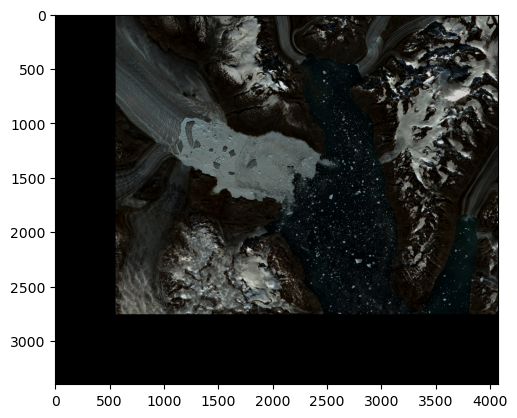

In [15]:
time=2
rgb = np.dstack((xx.red.isel(time=time).values,
                 xx.green.isel(time=time).values,
                 xx.blue.isel(time=time).values))
# Normalize the RGB data
rgb_norm = rgb / rgb.max()

# Display the normalized RGB image using plt.imshow
plt.imshow(rgb_norm)

In [16]:
time=2


def plot_rbg(time, image_stac):
    rgb = np.dstack((image_stac.red.isel(time=time).values,
                     image_stac.green.isel(time=time).values,
                     image_stac.blue.isel(time=time).values))
    # Normalize the RGB data
    rgb_norm = rgb / rgb.max()
    
    # Display the normalized RGB image using plt.imshow
    plt.imshow(rgb_norm)
    


In [17]:
items

[<Item id=S2A_MSIL2A_20160727T140022_R010_T25WES_20210528T225642>,
 <Item id=S2A_MSIL2A_20160726T142942_R139_T25WES_20210212T081644>,
 <Item id=S2A_MSIL2A_20160723T141952_R096_T25WES_20210212T071825>,
 <Item id=S2A_MSIL2A_20160720T141012_R053_T25WES_20210212T062332>,
 <Item id=S2A_MSIL2A_20160717T140022_R010_T25WES_20210212T052702>,
 <Item id=S2A_MSIL2A_20160716T142942_R139_T25WES_20210212T050920>,
 <Item id=S2A_MSIL2A_20160713T141952_R096_T25WES_20210212T041530>,
 <Item id=S2A_MSIL2A_20160706T142952_R139_T25WES_20210212T020316>,
 <Item id=S2A_MSIL2A_20160703T142012_R096_T25WES_20210212T013445>]

In [18]:
items[-3]
items2keep = []

In [19]:
items2keep.append(items[-3])
items2keep

[<Item id=S2A_MSIL2A_20160713T141952_R096_T25WES_20210212T041530>]

In [20]:
items2 = stac_query("2019-03")
cube_1903 = stac_load_help(items2)
cube_1903

Found: 1 datasets


<xarray.Dataset> Size: 111MB
Dimensions:      (y: 3399, x: 4071, time: 1)
Coordinates:
  * y            (y) float64 27kB 7.618e+06 7.618e+06 ... 7.584e+06 7.584e+06
  * x            (x) float64 33kB 4.944e+05 4.944e+05 ... 5.351e+05 5.351e+05
    spatial_ref  int32 4B 32625
  * time         (time) datetime64[ns] 8B 2019-03-04T14:00:51.024000
Data variables:
    red          (time, y, x) uint16 28MB dask.array<chunksize=(1, 3399, 4071), meta=np.ndarray>
    green        (time, y, x) uint16 28MB dask.array<chunksize=(1, 3399, 4071), meta=np.ndarray>
    blue         (time, y, x) uint16 28MB dask.array<chunksize=(1, 3399, 4071), meta=np.ndarray>
    nir          (time, y, x) uint16 28MB dask.array<chunksize=(1, 3399, 4071), meta=np.ndarray>

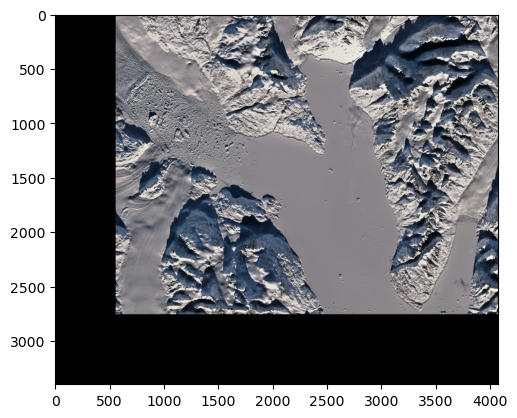

In [21]:
plot_rbg(0, cube_1903)

In [22]:
items2keep.append(items2[0])

In [23]:
items2keep

[<Item id=S2A_MSIL2A_20160713T141952_R096_T25WES_20210212T041530>,
 <Item id=S2A_MSIL2A_20190304T140051_R010_T25WES_20201030T131654>]

In [24]:
items3 = stac_query("2020-09")
cube_202009 = stac_load_help(items3)
cube_202009

Found: 11 datasets


<xarray.Dataset> Size: 1GB
Dimensions:      (y: 3399, x: 4071, time: 11)
Coordinates:
  * y            (y) float64 27kB 7.618e+06 7.618e+06 ... 7.584e+06 7.584e+06
  * x            (x) float64 33kB 4.944e+05 4.944e+05 ... 5.351e+05 5.351e+05
    spatial_ref  int32 4B 32625
  * time         (time) datetime64[ns] 88B 2020-09-02T14:07:39.024000 ... 202...
Data variables:
    red          (time, y, x) uint16 304MB dask.array<chunksize=(1, 3399, 4071), meta=np.ndarray>
    green        (time, y, x) uint16 304MB dask.array<chunksize=(1, 3399, 4071), meta=np.ndarray>
    blue         (time, y, x) uint16 304MB dask.array<chunksize=(1, 3399, 4071), meta=np.ndarray>
    nir          (time, y, x) uint16 304MB dask.array<chunksize=(1, 3399, 4071), meta=np.ndarray>

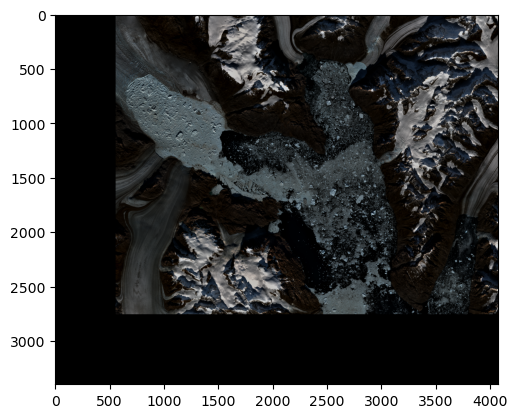

In [25]:
plot_rbg(5, cube_202009)

In [26]:
items2keep.append(items3[5])

In [27]:
items4 = stac_query("2024-05")
cube_202405 = stac_load_help(items4)

Found: 8 datasets


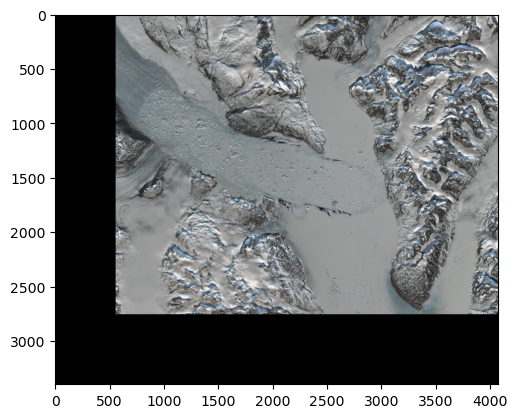

In [28]:
plot_rbg(2, cube_202405)

In [29]:
items4[-3]

<Item id=S2B_MSIL2A_20240514T140729_R053_T25WES_20240514T163024>

In [30]:
items2keep.append(items4[-3])
items2keep

[<Item id=S2A_MSIL2A_20160713T141952_R096_T25WES_20210212T041530>,
 <Item id=S2A_MSIL2A_20190304T140051_R010_T25WES_20201030T131654>,
 <Item id=S2B_MSIL2A_20200912T140739_R053_T25WES_20200918T131859>,
 <Item id=S2B_MSIL2A_20240514T140729_R053_T25WES_20240514T163024>]

In [31]:
import pickle

with open('kanger_image_item_list.pkl', 'wb') as f:
    pickle.dump(items2keep, f)

In [32]:
cube_202405.odc.crs

CRS('PROJCRS["WGS 84 / UTM zone 25N",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["UTM zone 25N",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-33,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",0.9996,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",500000,LENGTHUNIT["metre",1],ID[

In [33]:
test_stac = stac_load(
    items2keep,
    chunks={},
    bands=["red", "green", "blue"],
    patch_url=pc.sign,
    resolution=resolution,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
    geopolygon=kanger_mel
)


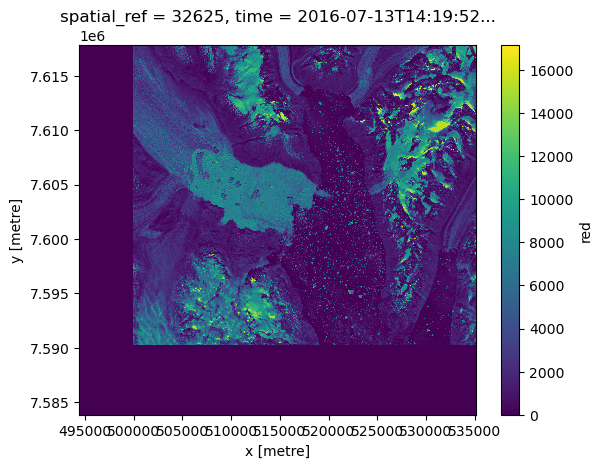

In [36]:
test_stac.red.isel(time=0).plot()

In [37]:
for time in test_stac.time:
    
    rgb = np.dstack((test_stac.red.sel(time=time).values,
                     test_stac.green.sel(time=time).values,
                     test_stac.blue.sel(time=time).values))

In [39]:
test_stac.to_netcdf('kanger_netcdf.nc')